In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def convert(imgs, labels, cnt):
    imgf = open(imgs, "rb")
    labelf = open(labels, "rb")
    
    imgf.read(16)
    labelf.read(8)
    images = []
    
    for i in range(cnt):
        image = [ord(labelf.read(1))]
        for j in range(28*28):
            image.append(ord(imgf.read(1)))
        images.append(image);
    
    images = np.array(images)
    
    inputs = images[:, 1:]
    outputs = images[:, 0]
    return (inputs, outputs)

def get_mnist():
    mnist_train_x = "train-images.ubyte"
    mnist_train_y = "train-labels.ubyte"
    mnist_test_x = "test-images.ubyte"
    mnist_test_y = "test-labels.ubyte"
    train_data = convert(mnist_train_x, mnist_train_y, 60000)
    test_data = convert(mnist_test_x, mnist_test_y, 10000)
    return train_data, test_data
    

In [4]:
train_data, test_data = get_mnist()

In [5]:
(x_train, y_train) = train_data
(x_test, y_test) = test_data

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
type(x_train), type(y_train), type(x_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [8]:
x_train[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
y_train[:5]

array([5, 0, 4, 1, 9])

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

5


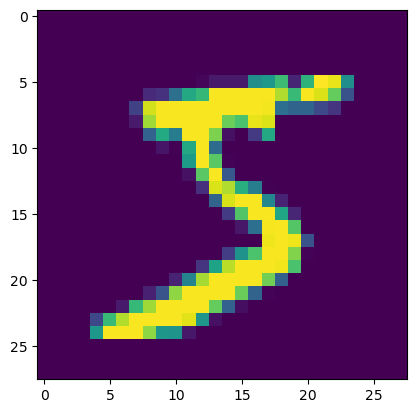

In [11]:
plt.imshow(x_train[0].reshape((28, 28)))
print(y_train[0])

In [12]:
# Normalize inputs 
x_train = x_train / 255
x_test = x_test / 255

In [13]:
# One Hot Encode outputs
def OHE(y):
    one_hot = np.zeros((len(y), 10))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y_train = OHE(y_train)
y_test = OHE(y_test)
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [31]:
class DNN:
    def __init__(self, sizes, epochs=10, lr=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr
        self.number_of_layers = len(sizes)
        
        self.params = {}
        
        for l in range(1, self.number_of_layers):
            self.params['W' + str(l)] = np.random.randn(sizes[l], sizes[l-1]) * np.sqrt(2/sizes[l-1])
            self.params['b' + str(l)] = np.zeros((sizes[l], 1))

    def relu(self, x, derivative = False):
        if derivative:
            return x > 0
        return np.maximum(x, 0)

    def softmax(self, x, derivative = False):
        exps = np.exp(x)

        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
  
    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train.T # 784 x 60000
        assert(params['A0'].shape == (784, x_train.shape[0]))
        
        m = params['A0'].shape[1]
        
        for l in range(1, self.number_of_layers - 1):
            params['Z' + str(l)] = np.matmul(params['W' + str(l)], params['A' + str(l-1)]) + params['b' + str(l)]
            params['A' + str(l)] = self.relu(params['Z' + str(l)])


        #hidden layers to output_layer
        params['Z' + str(self.number_of_layers - 1)] = np.matmul(params['W' + str(self.number_of_layers - 1)], 
                                                                 params['A' + str(self.number_of_layers - 2)]) + params['b' + str(self.number_of_layers - 1)]
        params['A' + str(self.number_of_layers - 1)] = self.softmax(params['Z' + str(self.number_of_layers - 1)])

        return params['A' + str(self.number_of_layers - 1)]

    def backward_pass(self, y_train, output):
        params = self.params

        changes = {}
        
        m = output.shape[1]
        
        changes['Z' + str(self.number_of_layers - 1)] = (output - y_train.T)
        changes['W' + str(self.number_of_layers - 1)] = 1 / m * np.matmul(changes['Z' + str(self.number_of_layers - 1)], 
                                                                          params['A' + str(self.number_of_layers - 2)].T)
        changes['b' + str(self.number_of_layers - 1)] = 1 / m * np.sum(changes['Z' + str(self.number_of_layers - 1)], axis=1, keepdims=True)
        
        for l in reversed(range(1, self.number_of_layers - 1)):
            changes['Z' + str(l)] = np.dot(params['W' + str(l+1)].T, changes['Z' + str(l+1)]) * self.relu(params['Z' + str(l)],derivative=True)
            changes['W' + str(l)] = 1 / m * np.matmul(changes['Z' + str(l)], params['A' + str(l-1)].T)
            changes['b' + str(l)] = 1 / m * np.sum(changes['Z' + str(l)], axis=1, keepdims=True)

        return changes

    def update_weights(self, changes):
        for key, value in changes.items():
            self.params[key] -= self.lr * value  # W_t + 1 = W_t - lr * Delta_W_t

    def compute_accuracy(self, x_test, y_test):
        output = self.forward_pass(x_test)
        pred = np.argmax(output, axis=0)

        return np.mean(pred == y_test.argmax(axis=1))

    def train(self, x_train, x_test, y_train, y_test):
        for i in range(self.epochs):
            output = self.forward_pass(x_train)
            changes = self.backward_pass(y_train, output)
            self.update_weights(changes)
            if i % 20 == 0:
                training_accuracy = self.compute_accuracy(x_train, y_train)
                test_accuracy = self.compute_accuracy(x_test, y_test)
                print('epoch: {0}, training accuracy: {1:.2f}%, test accuracy: {2:.2f}%'.format(i+1, 
                                                                                                training_accuracy*100, 
                                                                                                test_accuracy*100))
        
        training_accuracy = self.compute_accuracy(x_train, y_train)
        test_accuracy = self.compute_accuracy(x_test, y_test)
        print('epoch: {0}, training accuracy: {1:.2f}%, test accuracy: {2:.2f}%'.format(i+1, 
                                                                                        training_accuracy*100, 
                                                                                        test_accuracy*100))

    
      

In [32]:
x_test.shape, x_train.shape, y_train.shape

((10000, 784), (60000, 784), (60000, 10))

In [48]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=300, lr=0.1)
dnn.train(x_train, x_test, y_train, y_test)

epoch: 1, training accuracy: 11.39%, test accuracy: 11.54%
epoch: 21, training accuracy: 75.20%, test accuracy: 75.42%
epoch: 41, training accuracy: 84.62%, test accuracy: 85.13%
epoch: 61, training accuracy: 87.30%, test accuracy: 88.18%
epoch: 81, training accuracy: 88.66%, test accuracy: 89.40%
epoch: 101, training accuracy: 89.51%, test accuracy: 90.17%
epoch: 121, training accuracy: 90.10%, test accuracy: 90.73%
epoch: 141, training accuracy: 90.61%, test accuracy: 91.20%
epoch: 161, training accuracy: 91.02%, test accuracy: 91.57%
epoch: 181, training accuracy: 91.33%, test accuracy: 91.88%
epoch: 201, training accuracy: 91.62%, test accuracy: 92.18%
epoch: 221, training accuracy: 91.88%, test accuracy: 92.36%
epoch: 241, training accuracy: 92.12%, test accuracy: 92.55%
epoch: 261, training accuracy: 92.35%, test accuracy: 92.73%
epoch: 281, training accuracy: 92.55%, test accuracy: 92.90%
epoch: 300, training accuracy: 92.71%, test accuracy: 93.07%


In [51]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=300, lr=0.13)
dnn.train(x_train, x_test, y_train, y_test)

epoch: 1, training accuracy: 16.00%, test accuracy: 15.70%
epoch: 21, training accuracy: 82.49%, test accuracy: 82.93%
epoch: 41, training accuracy: 86.39%, test accuracy: 86.99%
epoch: 61, training accuracy: 88.73%, test accuracy: 88.97%
epoch: 81, training accuracy: 89.85%, test accuracy: 90.17%
epoch: 101, training accuracy: 90.48%, test accuracy: 90.84%
epoch: 121, training accuracy: 91.00%, test accuracy: 91.32%
epoch: 141, training accuracy: 91.48%, test accuracy: 91.72%
epoch: 161, training accuracy: 91.84%, test accuracy: 92.01%
epoch: 181, training accuracy: 92.17%, test accuracy: 92.33%
epoch: 201, training accuracy: 92.48%, test accuracy: 92.57%
epoch: 221, training accuracy: 92.72%, test accuracy: 92.73%
epoch: 241, training accuracy: 92.99%, test accuracy: 92.96%
epoch: 261, training accuracy: 93.21%, test accuracy: 93.13%
epoch: 281, training accuracy: 93.44%, test accuracy: 93.31%
epoch: 300, training accuracy: 93.60%, test accuracy: 93.50%


In [54]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=300, lr=0.14)
dnn.train(x_train, x_test, y_train, y_test)

epoch: 1, training accuracy: 17.50%, test accuracy: 17.04%
epoch: 21, training accuracy: 82.36%, test accuracy: 83.24%
epoch: 41, training accuracy: 87.03%, test accuracy: 87.82%
epoch: 61, training accuracy: 89.10%, test accuracy: 89.48%
epoch: 81, training accuracy: 90.02%, test accuracy: 90.33%
epoch: 101, training accuracy: 90.67%, test accuracy: 90.98%
epoch: 121, training accuracy: 91.20%, test accuracy: 91.51%
epoch: 141, training accuracy: 91.58%, test accuracy: 91.92%
epoch: 161, training accuracy: 91.97%, test accuracy: 92.33%
epoch: 181, training accuracy: 92.30%, test accuracy: 92.53%
epoch: 201, training accuracy: 92.60%, test accuracy: 92.80%
epoch: 221, training accuracy: 92.83%, test accuracy: 93.09%
epoch: 241, training accuracy: 93.11%, test accuracy: 93.35%
epoch: 261, training accuracy: 93.30%, test accuracy: 93.53%
epoch: 281, training accuracy: 93.51%, test accuracy: 93.70%
epoch: 300, training accuracy: 93.70%, test accuracy: 93.79%


In [55]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=300, lr=0.15)
dnn.train(x_train, x_test, y_train, y_test)

epoch: 1, training accuracy: 26.16%, test accuracy: 26.07%
epoch: 21, training accuracy: 81.64%, test accuracy: 82.28%
epoch: 41, training accuracy: 86.18%, test accuracy: 86.68%
epoch: 61, training accuracy: 88.62%, test accuracy: 89.43%
epoch: 81, training accuracy: 89.71%, test accuracy: 90.28%
epoch: 101, training accuracy: 90.20%, test accuracy: 90.76%
epoch: 121, training accuracy: 91.15%, test accuracy: 91.53%
epoch: 141, training accuracy: 91.64%, test accuracy: 91.92%
epoch: 161, training accuracy: 92.03%, test accuracy: 92.28%
epoch: 181, training accuracy: 92.38%, test accuracy: 92.57%
epoch: 201, training accuracy: 92.71%, test accuracy: 92.80%
epoch: 221, training accuracy: 92.98%, test accuracy: 93.08%
epoch: 241, training accuracy: 93.23%, test accuracy: 93.21%
epoch: 261, training accuracy: 93.45%, test accuracy: 93.40%
epoch: 281, training accuracy: 93.62%, test accuracy: 93.62%
epoch: 300, training accuracy: 93.81%, test accuracy: 93.76%


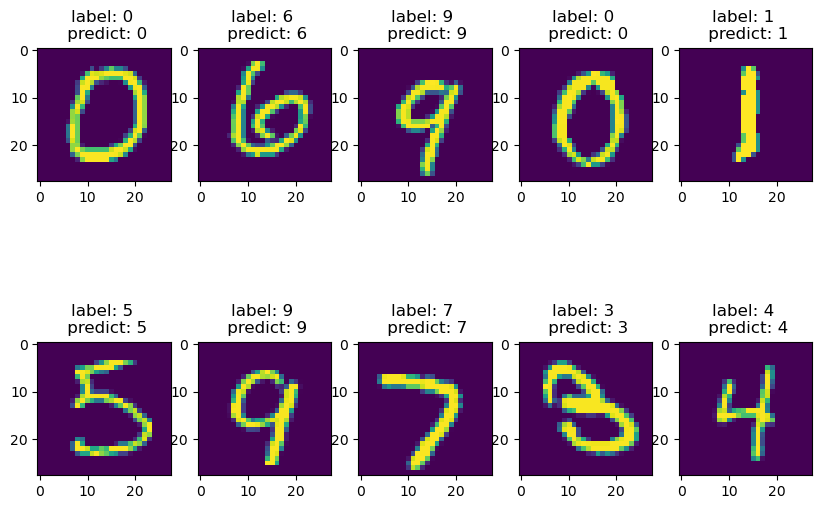

In [56]:
fig, axs = plt.subplots(2, 5, figsize=(10,7))
for i in range(10,20):
    idx = i - 10
    axs[idx//5, idx%5].imshow(x_test[i].reshape(28, 28))
    axs[idx//5, idx%5].set_title("label: {0} \n predict: {1}".format(y_test[i].argmax(), dnn.forward_pass(x_test[i].reshape((1, -1))).argmax()))

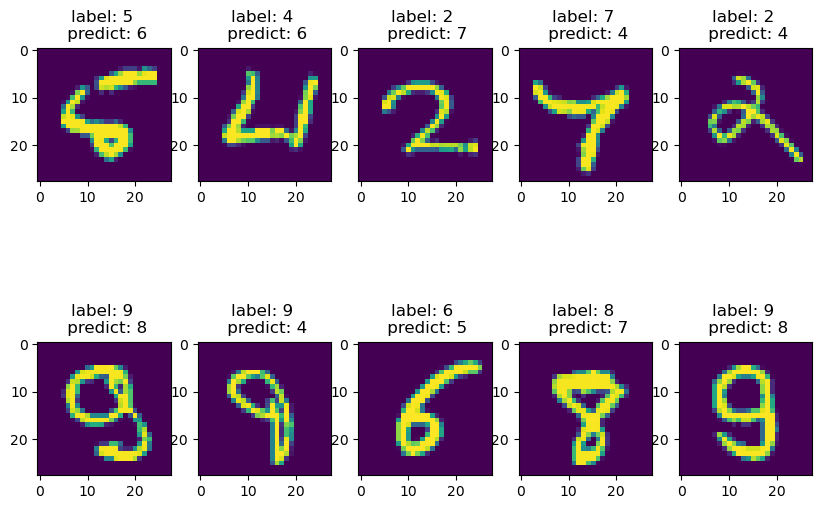

In [57]:
errors = []
for i in range(1000):
    if y_test[i].argmax() != dnn.forward_pass(x_test[i].reshape(1, -1)).argmax():
        errors.append(i)
        if len(errors) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(10,7))
idx = 0
for i in errors:
    axs[idx//5, idx%5].imshow(x_test[i].reshape(28, 28))
    axs[idx//5, idx%5].set_title("label: {0} \n predict: {1}".format(y_test[i].argmax(), dnn.forward_pass(x_test[i].reshape(1, -1)).argmax()))
    idx = idx + 1